## Лабораторная работа №2 по курсу "Интеллектуальный анализ данных"

выполнил Сорокин Никита, М8О-403Б-20

### 2.1 Классификация датасета Титаник с помощью решающих деревьев

In [59]:
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

sns.set()

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

Загрузка датасета в pandas

In [33]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Предобработка данных:

In [34]:
def preprocess_data(df):
    df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
    df = pd.get_dummies(df)
    mean_age = df['Age'].mean()
    print(mean_age)
    df['Age'].fillna(mean_age, inplace=True)

    return df

In [35]:
df_new = preprocess_data(df)
df_new

29.69911764705882


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,0,3,22.000000,1,0,7.2500,0,1
1,2,1,1,38.000000,1,0,71.2833,1,0
2,3,1,3,26.000000,0,0,7.9250,1,0
3,4,1,1,35.000000,1,0,53.1000,1,0
4,5,0,3,35.000000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0,1
887,888,1,1,19.000000,0,0,30.0000,1,0
888,889,0,3,29.699118,1,2,23.4500,1,0
889,890,1,1,26.000000,0,0,30.0000,0,1


Разбивка на тренировочную и валидационную выборку:

In [54]:
X_train, X_val, y_train, y_val = train_test_split(df_new.iloc[:, 2:], df_new.iloc[:, 1], random_state=17)



Визуализация полученной модели:

In [60]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

Обучим модели с разными критериями расщепления:

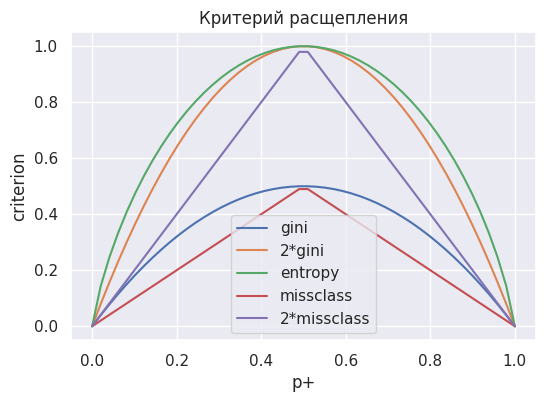

In [48]:
plt.figure(figsize=(6, 4))
xx = np.linspace(0, 1, 50)
plt.plot(xx, [2 * x * (1 - x) for x in xx], label="gini")
plt.plot(xx, [4 * x * (1 - x) for x in xx], label="2*gini")
plt.plot(xx, [0 if x in [0, 1] else -x * np.log2(x) - (1 - x) * np.log2(1 - x) for x in xx], label="entropy")
plt.plot(xx, [1 - max(x, 1 - x) for x in xx], label="missclass")
plt.plot(xx, [2 - 2 * max(x, 1 - x) for x in xx], label="2*missclass")
plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Критерий расщепления")
plt.legend();

### Обучение: Gini

In [68]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3).fit(X_train, y_train)

In [69]:
tree_graph_to_png(
    tree=clf_gini,
    feature_names=df_new.columns[2:],
    png_file_to_save='tree_gini.png',
)

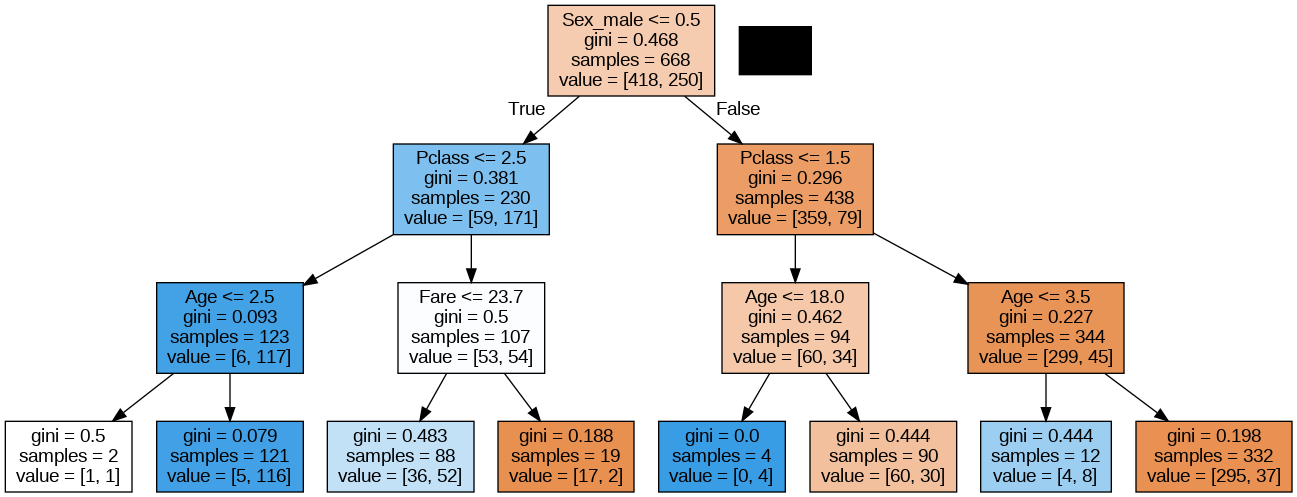

In [70]:
Image(filename='tree_gini.png')

In [71]:
y_pred_gini = clf_gini.predict(X_val)

In [72]:
print(classification_report(y_val, y_pred_gini))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       131
           1       0.78      0.71      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



### Обучение: Entropy

In [84]:
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X_train, y_train)

In [85]:
tree_graph_to_png(
    tree=clf_entropy,
    feature_names=df_new.columns[2:],
    png_file_to_save='tree_entropy.png',
)

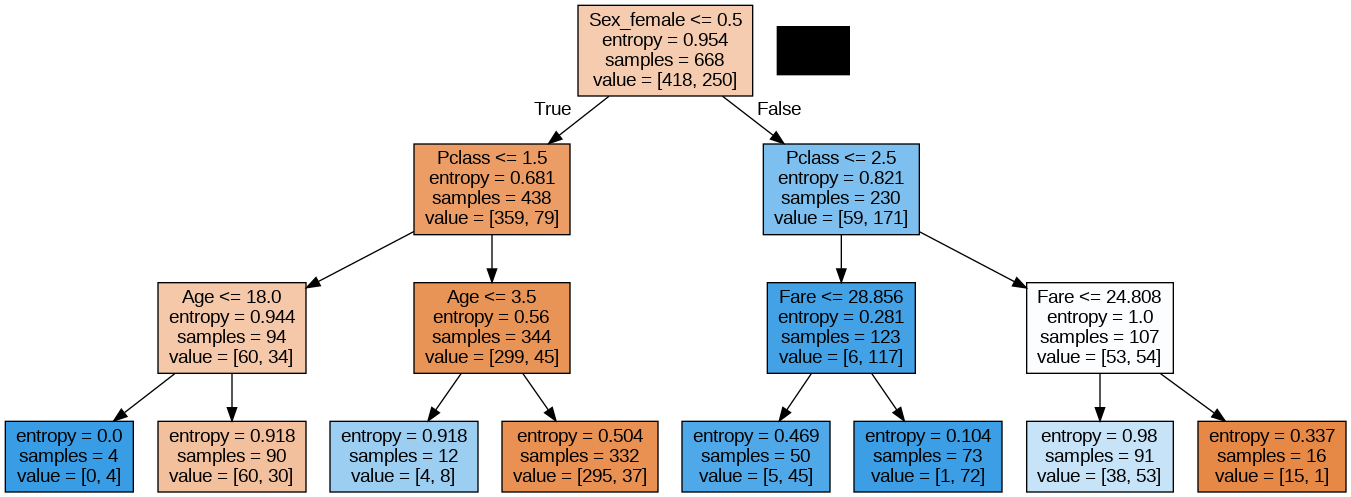

In [86]:
Image(filename='tree_entropy.png')

In [87]:
y_pred_entropy = clf_entropy.predict(X_val)

In [89]:
print(classification_report(y_val, y_pred_entropy))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       131
           1       0.78      0.71      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



### Обучение: Log loss

In [100]:
clf_ll = DecisionTreeClassifier(criterion='log_loss', max_depth=3).fit(X_train, y_train)

In [101]:
tree_graph_to_png(
    tree=clf_ll,
    feature_names=df_new.columns[2:],
    png_file_to_save='tree_ll.png',
)

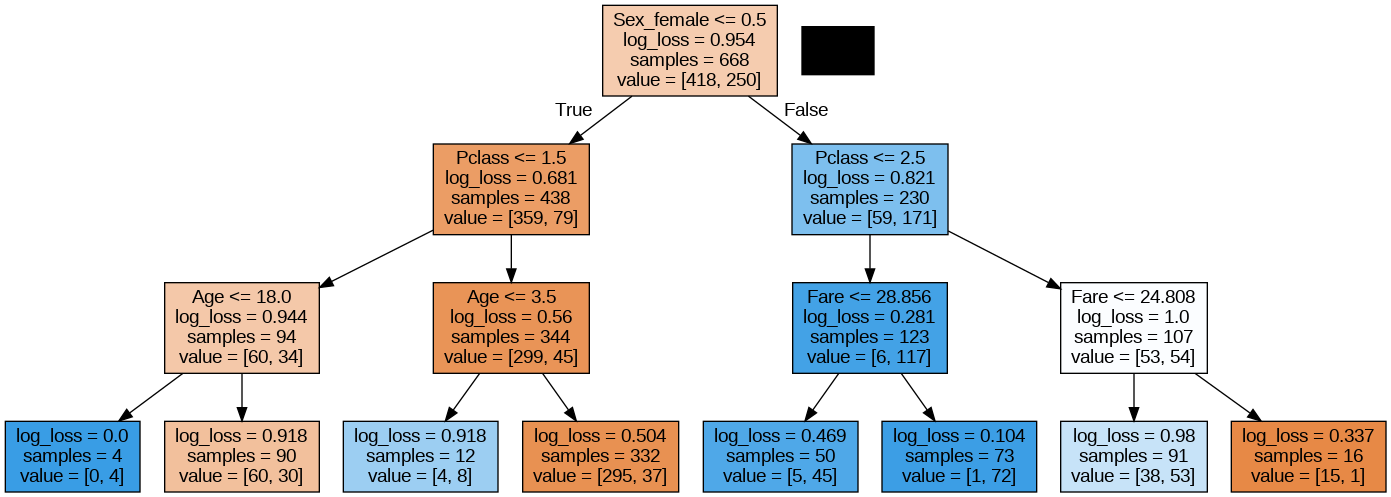

In [102]:
Image(filename='tree_ll.png')

In [103]:
y_pred_ll = clf_ll.predict(X_val)

In [104]:
print(classification_report(y_val, y_pred_ll))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       131
           1       0.78      0.71      0.74        92

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

